In [306]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

plot_save_dir = "/global/homes/v/virajvm/galaxy_image_prior/paper_1"


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs, process_img
from desi_lowz_funcs import calc_normalized_dist, sdss_rgb, get_scrollable_pdfs
from desi_lowz_funcs import find_objects_nearby, print_radecs
# from construct_dwarf_galaxy_catalogs import process_sga_matches

import warnings
from astropy.wcs import FITSFixedWarning

# Suppress just FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)


%load_ext autoreload
%autoreload 2

# python3 desi_dwarfs/code/dwarf_photo_pipeline.py -sample SGA -min 0 -max 100000 -run_parr -ncores 1 -overwrite -nchunks 1 -no_cnn_cut -use_sample sga -run_aper -run_cog -tgids 39628500637844206


def get_vi_pdf(cat_vi, name, png_type = "cog"):
    
    all_sga_outlier_files = []
    
    for i in range(len(cat_vi)):
        bool_type = cat_vi["ISOLATE_MASK_LIKELY_SHREDDING"].data[i]
        file_path = cat_vi["FILE_PATH"].data[i]
        if isinstance(file_path, bytes):
            file_path = file_path.decode()     
        else:
            pass  

        if png_type == "cog":
            if bool_type:
                #we use the no_isolate one
                file_i = os.path.join(file_path, "cog_summary_no_isolate.png")
            else:
                file_i = os.path.join(file_path, "cog_summary.png")

        else:
            file_i =  os.path.join(file_path, "grz_bands_segments.png")
  
        all_sga_outlier_files.append(file_i)


    get_scrollable_pdfs(all_sga_outlier_files, f"/pscratch/sd/v/virajvm/trash/{name}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [307]:
from isolate_galaxy_mask import get_isolate_galaxy_mask, make_custom_cmap
    
cmap_cstm = make_custom_cmap(8, cmap_name="tab10")

from consolidate_photometry import consolidate_new_photo, get_fastspec_matched_catalog


In [308]:
from sga_nsa_comp_funcs import make_compare_plot_3bands
from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes

import cmasher as cmr

In [309]:
def do_consolidate(cat,sample):
    cat = consolidate_new_photo(cat,sample=sample)
    cat = consolidate_positions_and_shapes(cat)
    cat = cat[cat["PHOTO_MASKBIT"] == 0]
    return cat


In [310]:
bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
bgsf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
lowz_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
elg_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")


bgsb_cat = do_consolidate(bgsb_cat,"BGS_BRIGHT")
print("--"*10)
bgsf_cat = do_consolidate(bgsf_cat,"BGS_FAINT")
print("--"*10)
elg_cat = do_consolidate(elg_cat,"ELG")
print("--"*10)

lowz_cat = do_consolidate(lowz_cat,"LOWZ")
print("--"*10)

sga_cat = do_consolidate(sga_cat,"SGA")



Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.23503663526501095
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0031
MASKBIT=2^1, cog not converge, fraction: 0.058949
MASKBIT=2^2, bad resid, fraction : 0.0056
MASKBIT=2^3, cog curve decrease, fraction: 0.0096
MASKBIT=2^4, aperfrac-in image, fraction: 0.001047
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047007
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.000333
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.048958
MASKBIT=2^11, no seg found, fraction: 0.000048
MASKBIT=2^13, near sga outskirts, fraction: 0.013798
Fraction of sources where org trac is likely good = 0.5378247216671425
Updating the maskbits to reflect some objects reverted to original Tractor photometry
MASKBIT=

100%|██████████| 21018/21018 [00:00<00:00, 297304.65it/s]

Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column


--------------------
Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.31032412965186074
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0096
MASKBIT=2^1, cog not converge, fraction: 0.082233
MASKBIT=2^2, bad resid, fraction : 0.0114
MASKBIT=2^3, cog curve decrease, fraction: 0.0066
MASKBIT=2^4, aperfrac-in image, fraction: 0.000300
MASKBIT=2^5, aperfrac-mask image, fraction: 0.124850
MASKBIT=2^6, image-frac mask, fraction: 0.000900
MASKBIT=2^7, bad colors, fraction: 0.000600
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.110444
MASKBIT=2^10, aper-cen masked, fraction: 0.110144
MASKBIT=2^11, no seg found, fraction: 0.000300
MASKBIT=2^13, near sga outskirts, fraction: 0.006603
Fraction of sources where org trac is likely good = 0.46278511404561823
Updating the maskbits to reflect some objects reverted to original Tract

100%|██████████| 3332/3332 [00:00<00:00, 280512.65it/s]


Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------
Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.1954395474899835
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.1824
MASKBIT=2^1, cog not converge, fraction: 0.033879
MASKBIT=2^2, bad resid, fraction : 0.0025
MASKBIT=2^3, cog curve decrease, fraction: 0.0014
MASKBIT=2^4, aperfrac-in image, fraction: 0.000334
MASKBIT=2^5, aperfrac-mask image, fraction: 0.195204
MASKBIT=2^6, image-frac mask, fraction: 0.001355
MASKBIT=2^7, bad colors, fraction: 0.001375
MASKBIT=2^8, source not on segment, fraction: 0.0041
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.045997
MASKBIT=2^10, aper-cen masked, fraction: 0.017244
MASKBIT=2^11, no seg found, fraction: 0.029991
MASKBIT=2^13, near sga outskirts, fraction: 0.005617
Fraction of sources where org trac is likely good = 0.19938

/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/consolidate_photometry.py:353: RuntimeWarning: overflow encountered in double_scalars
  
100%|██████████| 50916/50916 [00:00<00:00, 299506.59it/s]


Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------
Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.5029171528588098
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0070
MASKBIT=2^1, cog not converge, fraction: 0.185531
MASKBIT=2^2, bad resid, fraction : 0.0023
MASKBIT=2^3, cog curve decrease, fraction: 0.0093
MASKBIT=2^4, aperfrac-in image, fraction: 0.000000
MASKBIT=2^5, aperfrac-mask image, fraction: 0.024504
MASKBIT=2^6, image-frac mask, fraction: 0.000000
MASKBIT=2^7, bad colors, fraction: 0.000000
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.099183
MASKBIT=2^10, aper-cen masked, fraction: 0.019837
MASKBIT=2^11, no seg found, fraction: 0.000000
MASKBIT=2^13, near sga outskirts, fraction: 0.002334
Fraction of sources where org trac is likely good = 0.50525

100%|██████████| 857/857 [00:00<00:00, 279794.39it/s]


Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------
Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.24194309070900802
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0009
MASKBIT=2^1, cog not converge, fraction: 0.028297
MASKBIT=2^2, bad resid, fraction : 0.0017
MASKBIT=2^3, cog curve decrease, fraction: 0.0033
MASKBIT=2^4, aperfrac-in image, fraction: 0.005659
MASKBIT=2^5, aperfrac-mask image, fraction: 0.001886
MASKBIT=2^6, image-frac mask, fraction: 0.000314
MASKBIT=2^7, bad colors, fraction: 0.000629
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.022324
MASKBIT=2^10, aper-cen masked, fraction: 0.005188
MASKBIT=2^11, no seg found, fraction: 0.000000
Fraction of sources where org trac is likely good = 0.3903474296494262
Updating the maskbits to reflect some ob

100%|██████████| 6361/6361 [00:00<00:00, 228704.39it/s]

Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column


In [311]:
# --- remove extra columns from SGA before stacking ---
extra_cols = set(sga_cat.colnames) - set(lowz_cat.colnames)
if extra_cols:
    print(f"Removing {len(extra_cols)} extra columns from SGA: {extra_cols}")
    sga_cat.remove_columns(list(extra_cols))

# optional: reorder columns to match LOWZ (keeps order consistent)
sga_cat = sga_cat[lowz_cat.colnames]

tot_shred = vstack([ bgsb_cat, bgsf_cat, lowz_cat, elg_cat, sga_cat])



Removing 15 extra columns from SGA: {'SGA_RA_MOMENT', 'SGA_SMA_SB25', 'SGA_GR', 'SAMPLE_DESI', 'SGA_MAG_LEDA', 'SGA_PA', 'SGA_BA', 'SGA_G_COG_MAG', 'SGA_ID', 'SGA_SMA_SB26', 'SGA_Z_COG_MAG', 'SGA_LOGM_SAGA', 'SGA_R_COG_MAG', 'SGA_DEC_MOMENT', 'SGA_ZRED_LEDA'}


In [312]:
len(tot_shred)

67359

In [313]:
#also read in the nsa catalog
nsa_cat = Table.read("/pscratch/sd/v/virajvm/catalog/nsa_v1_0_1.fits")


In [316]:
##if I select within the half light radius then it is a good match!!

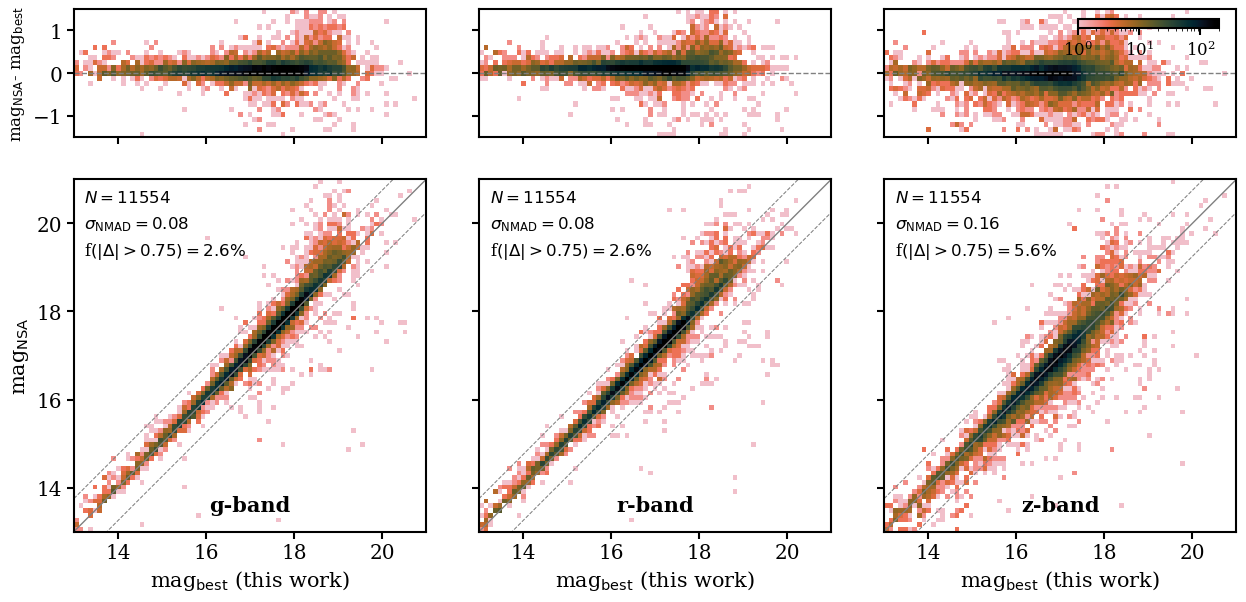

In [318]:
outlier_mask = (np.abs(nsa_mag_all[1] - best_mag_all[1]) > 0.75) & (nsa_mag_all[1] < 18)

In [319]:
np.sum(outlier_mask)/len(outlier_mask)

0.01021291327678726

In [29]:
## let us visualize the outliers!!

nsa_cat_outliers = desi_nsa_match_cat[outlier_mask]


In [31]:
get_vi_pdf(nsa_cat_outliers, "nsa_outliers_vi_cog.pdf", png_type = "cog")


Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/nsa_outliers_vi_cog.pdf


In [115]:
desi_nsa_match_cat[(desi_nsa_match_cat["Z"] < 0.01) & (desi_nsa_match_cat["Z"] > 0.005)]["RA","DEC","TARGETID"]

<Table length=860>
        RA                 DEC              TARGETID    
     float64             float64             int64      
------------------ ------------------- -----------------
173.51682124990813  -7.622316774360152 39627606835856569
127.27016900862581  -3.841587074581134 39627696287779429
 190.4835654402231   -3.65733875702524 39627697344746107
 217.0972426270925  -3.604635571568416 39627703824941798
212.85000545329703  -3.167295485405828 39627709785048356
189.26699398952334 -3.1206027918324097 39627715426386300
214.95276924474234  -2.082235367955554 39627740013401179
214.95277395457552  -2.082232045575666 39627740013401192
174.72646537770498  -1.642863615605471 39627745377915523
185.48263850727218  -1.593407323767258 39627751598068708
               ...                 ...               ...
223.92852994387488 -1.0092362427604615 39627764323586514
134.67088501692905   2.193650302338536 39627841343589611
188.11743535493002  0.3892803303611328 39627799962585446
213.82918572377568   36.20223794734603 39633005911738300
224.89528887636797   32.84145104226111 39632936248542770
 210.1051889663699  38.520617754181636 39633049155013063
 193.3583963388422   8.035513452274765 39627980753869373
 238.6598416112296  16.610419995838985 39628182197896424
237.31946950604802   21.83170743660259 39628302134019652
225.00552055508874 -1.0910558639255852 39627764344553699

Documenting what is going wrong!!


1) 39628510922280854, this should be shredded but our likely shredded criterion says isolate mask should not be applied!
z=0.011 and mu_r_R2 = 23.08, MAYBE THING TO BE DONE IS NOT MU_R IN APERTURE, BUT ALONG THE ISLAND!

2) 39627999334629687, very close together so hard to do, maybe the solution is that when we are predicting brigther than SGA, we revert to SGA?

3) 39628088539091024, WE DO BETTER HERE!!

4) 39633015600581503, accidentally called a star here. If the new aperture center falls on masked region that could be a sign of this?

5) 39633271088218330 -> difficult merger system

6) 39633458183540035 -> this is the weird ring system, when we compute fraction masked, does this include the other masked pixels too? or just the bad pixels? i think just bad pixels

7) 39627761270130297, 39627742404149820 -> example where SGA has 2 or more sources? How to know which one to use?

8) 39627653208085070, unclear why? missing data, some weird systematics are seen in image in r-band ...

9) 39627719486473819, another example where we do better!!

10) 


In [373]:
# # match_tgids = [39628138115762807, 39628242226776575, 39628343561161817, 39628376708745386]
# # better_tgids =  [39627761270130297, 39627719486473819, 39632976304146316, 39627873182548501]
# # worse_tgids = [ 39633324834032193, 39627915440163235, 39633489556931574, 39627696413606604 ]

match_tgids = [39627702776366521, 39627841343589611, 39627708749055631,39627601450375402,39627670568313160    ]
match_cutouts = [45,75,40,75,40]

match_tgids_p2 = [39628302134019652, 39627634593760082 ]
match_cutouts_p2 = [120,120 ]

better_tgids_top  = [39633182894589308, 39628268013357910, 39627763585388280, 39627679288266127, 39633358820476651,  39627756916443987]
better_cutouts_top = [140, 140, 45, 110,45, 90]

better_tgids_bot  = [39627697294412009, 39627929444942465, 39627703179023326, 39627697306992959, 39627703279686739]
better_cutouts_bot = [25, 25, 25, 25, 25]

better_tgids = better_tgids_bot + better_tgids_top
better_cutouts = better_cutouts_bot + better_cutouts_top

better_tgids_p2 = [ 39633318706153500,39627785555151004, 39627809517213943 , 39627997602383858, 39633153945502066]
better_cutouts_p2 = [75, 90, 50, 60, 90]


worse_tgids = [39627738985794919, 39628135691457089, 39628307825691449, 39628519919060183, 39633208593090958]
worse_cutouts  = [120, 140,75, 75, 75 ] 

ambi_tgids = [39627754362113195,  39627836813739445, 39633195536222566, 39628111796507282, 39627848981419490, 39627836750824798,]
ambi_cutouts = [80, 80, 45, 60, 90, 80]

# nsa_bad_tgids_paper = [39627658979442966, 39627709944432012, 39627663320547970, 39627643640878867, 39627793792766271, 39627889687135617, 39627503219771992, 39627672954867965, 39627720946092125, 39627733398983952, 39627739707214817, 39627745226918247]
# nsa_better_tgids_paper = [39633207930390678, 39628459877597639, 39627945148416047, 39627936113885462, 39627652578936400 ]



#combine this all in a dict
all_tgids = match_tgids + better_tgids + worse_tgids + ambi_tgids + match_tgids_p2 + better_tgids_p2
all_cutouts = match_cutouts + better_cutouts + worse_cutouts + ambi_cutouts + match_cutouts_p2 + better_cutouts_p2

cutout_size_dict = {}
for i,tgidi in enumerate(all_tgids):
    cutout_size_dict[tgidi] = all_cutouts[i]


In [330]:
from sga_nsa_comp_funcs import plot_one_panel_model_comp

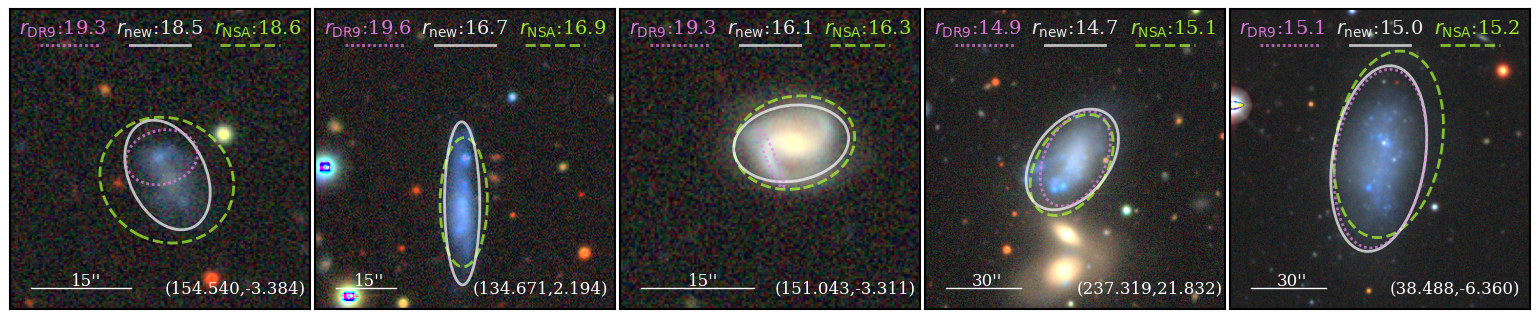

In [331]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(3):

    plot_one_panel_model_comp([ax[i]],match_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "greenyellow",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="violet",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ match_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)


for i in range(2):
    plot_one_panel_model_comp([ax[i+3]],match_tgids_p2[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "greenyellow",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="violet",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ match_tgids_p2[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=30,bar_size_str="30''", compare_sga=False)


# plt.savefig(f"plots/sga_match_comparison.png",bbox_inches="tight")

plt.show()

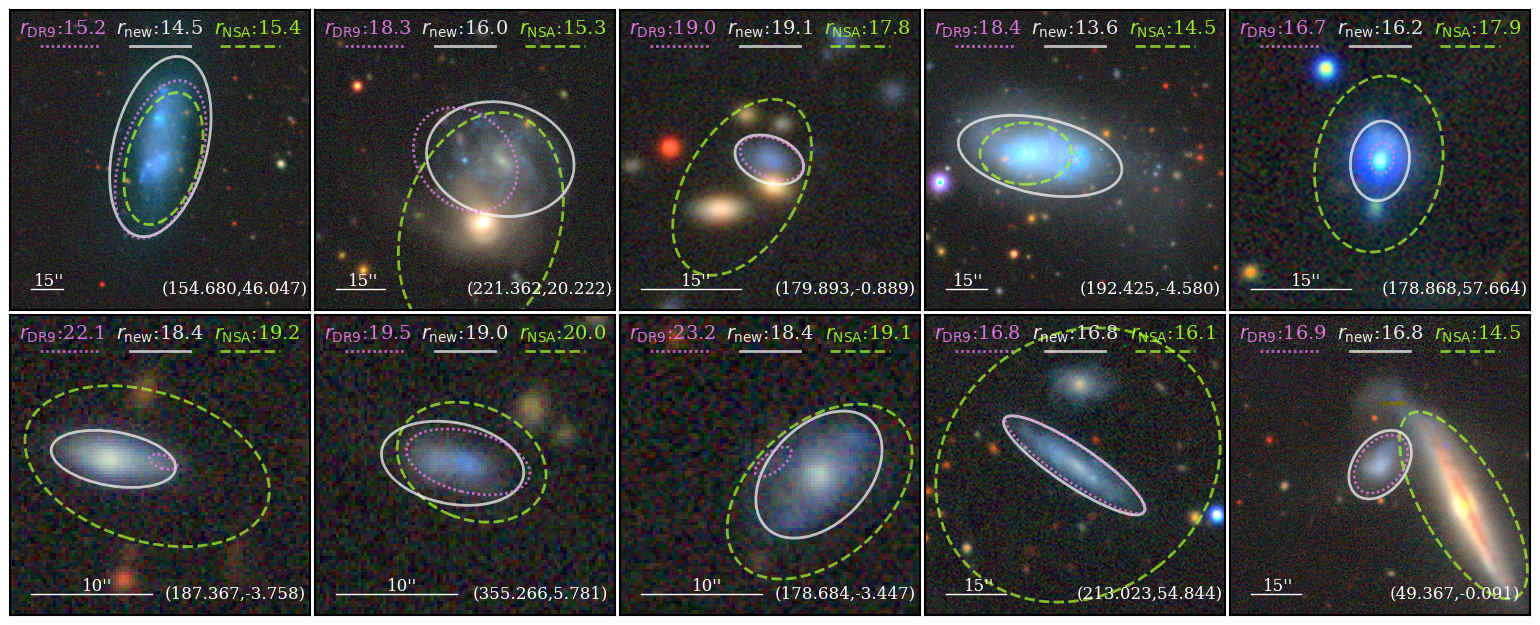

In [376]:
ax = make_subplots(ncol=5,nrow=2,col_spacing=0.05,plot_size=3,row_spacing=0.05)

for i in range(5,10):

    plot_one_panel_model_comp([ax[i]],better_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "greenyellow",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="violet",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ better_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)


for i in range(3):

    plot_one_panel_model_comp([ax[i]],better_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "greenyellow",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="violet",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ better_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=10,bar_size_str="10''", compare_sga=False)




for i in range(2):
    plot_one_panel_model_comp([ax[i+3]],better_tgids_p2[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "greenyellow",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="violet",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ better_tgids_p2[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)


# MOVE THE OTHER TO BE AMBI, AND MOVE THE TWO TO AGREEMENT

# plt.savefig(f"plots/sga_match_comparison.png",bbox_inches="tight")

plt.show()

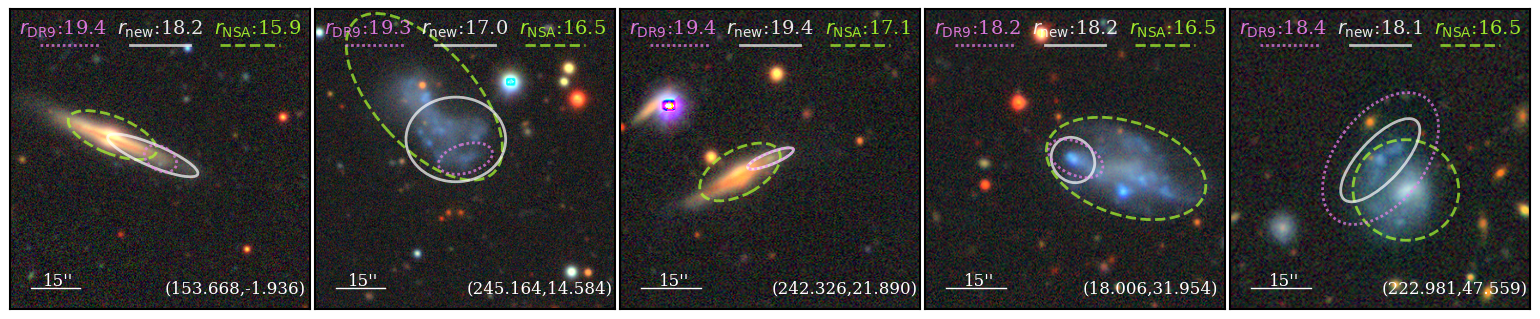

In [377]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(5):

    plot_one_panel_model_comp([ax[i]],worse_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "greenyellow",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="violet",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ worse_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)
    

# plt.savefig(f"plots/sga_match_comparison.png",bbox_inches="tight")

plt.show()

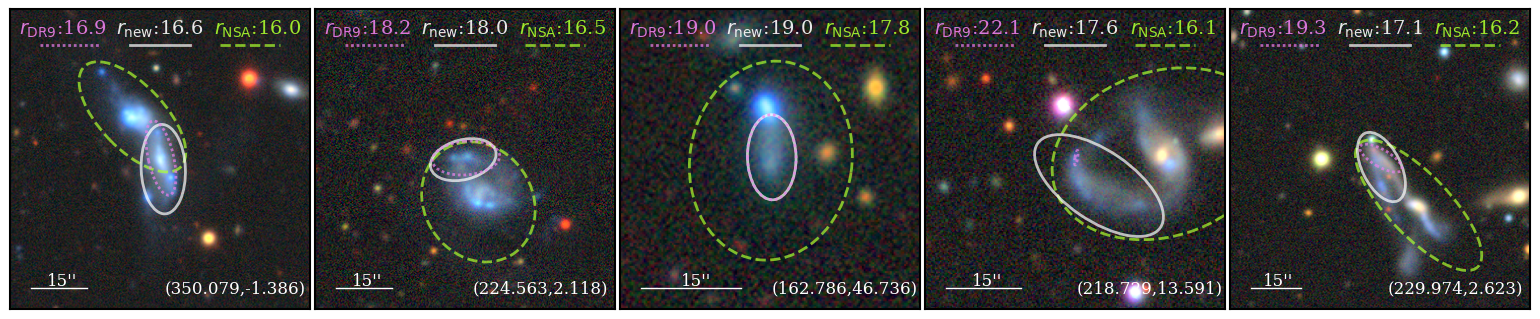

In [324]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(5):

    plot_one_panel_model_comp([ax[i]],ambi_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "greenyellow",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="violet",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ ambi_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)
    

# plt.savefig(f"plots/sga_match_comparison.png",bbox_inches="tight")

plt.show()

In [284]:
#39628500637844206 -> what is up with this star???
# 243.181,28.299,z = 0.024 > why this not flagged as outside??
tot_shred[tot_shred["TARGETID"]==39627781381822361]["MAG_TYPE","MAG_R","COG_MAG_R_FINAL"]



<Table length=1>
    MAG_TYPE       MAG_R    COG_MAG_R_FINAL  
     object       float32       float64      
---------------- --------- ------------------
TRACTOR_ORIGINAL 16.549385 16.489578394305717

In [277]:
# 39633318706153500, 39627785555151004
# 39627933584724963, 39633358820476651
# 39627866110953590
# 39628135691457089



In [381]:

# ax = make_subplots(ncol=1,nrow=1,col_spacing=0.05,plot_size=3)

# 39627769683907582, 39628268013357910


# plot_one_panel_model_comp([ax[0]],39628268013357910, desi_nsa_match_cat, nsa_match_cat,
#                              alpha=0.7,linewidth=2,
#                              sga_ls = "--",sga_color = "greenyellow",
#                              new_ls = "-", new_color = "white",
#                               trac_ls  = (0,(1,1)), trac_color="violet",
#                              scale_f = 2, cutout_size_arcsec = 120 ,
#                             verbose=False,use_sga_r50=True,
#                              bar_size_arc=30,bar_size_str="10''", compare_sga=False)

# plt.show()

In [102]:
def make_fracflux_compare_plot(all_fracs, new_mags, tractor_mags, ext_mags, title = "Comparison with SGA-2020 after cleaning",
              ylab_top = r"mag$_{\rm aper}$ - mag$_{\rm DR9}$", ylab_bot=r"mag$_{\rm aper}$ - mag$_{\rm SGA}$", 
           save_path = "plots/sga_trac_ff_comp.png"):
    
    ax = make_subplots(ncol = 1, nrow = 2, row_spacing = 0.3)

    if title is not None:
        ax[1].set_title(title,fontsize = 15)
    
    bins = 50

    all_dms = new_mags - tractor_mags
    
    all_dms_v2 = new_mags - ext_mags
    
    im = ax[1].hist2d( all_fracs, all_dms,
                 range=( (1e-2,5), (-5,0.5) ), bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],
                 norm=LogNorm(vmin=1,vmax=150),cmap = cmr.dusk_r, rasterized=True)
    
    im = ax[0].hist2d( all_fracs, all_dms_v2,
                 range=( (1e-2,5), (-5,0.5) ), bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],
                 norm=LogNorm(vmin=1,vmax=150),cmap = cmr.dusk_r,rasterized=True)


    for i in range(2):
        ax[i].set_xlim([1e-2,5])
        ax[i].set_ylim([-5,2])
        ax[i].set_xscale("log")
        ax[i].hlines(y = 0,xmin=1e-2, xmax = 5,ls = "-",color = "grey",lw =1 )
        ax[i].vlines(x = 0.2, ymin = -5, ymax = 2, color= "grey", ls = "--",lw = 1)
        ax[0].set_xlabel(r"FRACFLUX",fontsize = 15)
        ax[1].set_ylabel(ylab_top,fontsize = 15)
        ax[0].set_ylabel(ylab_bot, fontsize = 15)

    #insert a colorbar
    colbar_x, colbar_y = 0.0775, 0.08
    
    cbar = plt.colorbar(im[3], ax=ax[1], orientation='horizontal', pad=0.05)
    cbar.ax.set_position([
    colbar_x,   # Left position
    colbar_y,  # Top position
    ax[1].get_position().width * 0.065,  # Width (40% of plot width)
    0.015  # Height (thin bar)
    ])

    ax[1].set_xticklabels([])
    
    plt.savefig(save_path,bbox_inches="tight")
    plt.show()
    return


In [95]:
sga_trac_all = np.concatenate(sga_trac_mags_all)
sga_sga_mags_all = np.concatenate(sga_mags_all)
sga_aper_all = np.concatenate(sga_aper_mags_all)



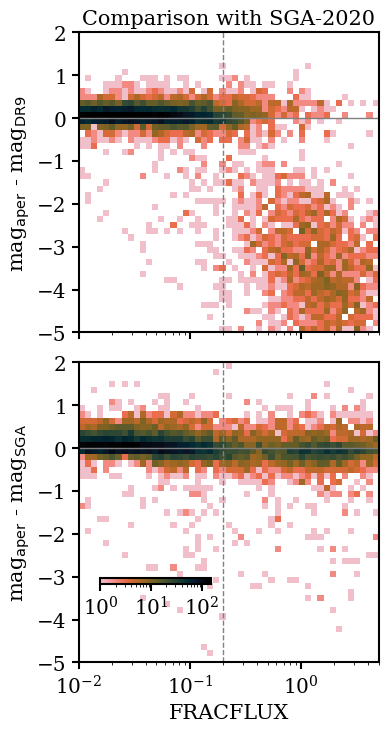

In [103]:
make_fracflux_compare_plot(ff_all, sga_aper_all, sga_trac_all, sga_sga_mags_all, title = "Comparison with SGA-2020",
              ylab_top = r"mag$_{\rm aper}$ - mag$_{\rm DR9}$", ylab_bot=r"mag$_{\rm aper}$ - mag$_{\rm SGA}$", 
           save_path = "plots/sga_trac_ff_comp.pdf")



In [99]:
nsa_nsa_mag_all = np.concatenate(nsa_mag_all)
nsa_trac_all = np.concatenate(nsa_trac_mag)
nsa_aper_all = np.concatenate(desi_match_mag_all)


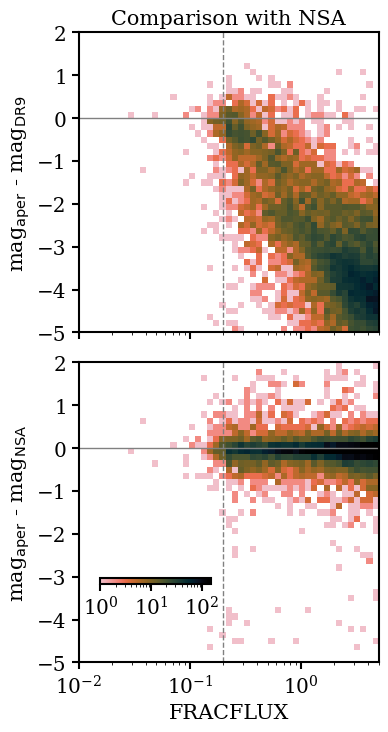

In [104]:
make_fracflux_compare_plot(nsa_ff_all, nsa_aper_all, nsa_trac_all, nsa_nsa_mag_all, title = "Comparison with NSA",
              ylab_top = r"mag$_{\rm aper}$ - mag$_{\rm DR9}$", ylab_bot=r"mag$_{\rm aper}$ - mag$_{\rm NSA}$", 
           save_path = "plots/nsa_trac_ff_comp.pdf")



Comparison with the 50MGC catalog

In [106]:
mgc_data = Table.read("/global/homes/v/virajvm/galaxy_image_prior/paper_1/datasets/catalog_50MPC.fits")
mgc_data_no_sga = mgc_data[(mgc_data["sga_obj"] == 0)] # & (mgc_data["nsa_obj"] == 1)
#we want to make a comparison that is not in SGA 
print(len(mgc_data))
print(len(tot_shred))

15424
38510


In [107]:
idx, d2d,_ = match_c_to_catalog(c_cat = mgc_data_no_sga, catalog_cat = tot_shred, c_ra="ra",c_dec="dec")

In [111]:
##as there is no radius information in the catalog, we simply adopt a 10 arcsec distance cutoff
mgc_match = mgc_data_no_sga[d2d.arcsec < 20]
desi_mgc_match = tot_shred[idx][d2d.arcsec < 20]
print(len(mgc_match))
np.unique(mgc_match["mag_flag"] )

136


<Column name='mag_flag' dtype='uint8' description='Flags galaxies with magnitude preference exceptions as described in Section 2.3' length=3>
0
1
2

In [113]:
from sga_nsa_comp_funcs import get_50mgc_Bmag
import cmasher as cmr
bmags_mgc = get_50mgc_Bmag(mgc_match)
desi_Bmag = desi_mgc_match["MAG_G_APERTURE_COG"].data + 0.39*(desi_mgc_match["MAG_G_APERTURE_COG"].data - desi_mgc_match["MAG_R_APERTURE_COG"].data) + 0.21



23
136


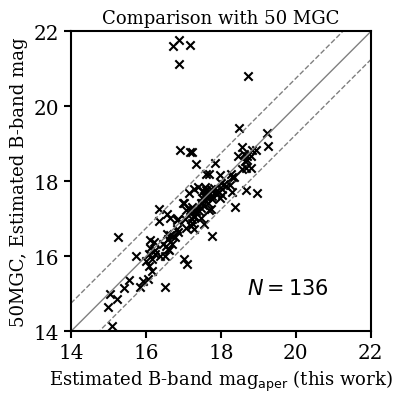

In [130]:
fig,ax = make_subplots(ncol = 1, nrow = 1,return_fig=True)

ax[0].set_title("Comparison with 50 MGC",fontsize = 13)

# im = ax[0].scatter(desi_Bmag,bmags_mgc,range=((14,22), (14,22)),bins=20,norm=LogNorm(vmin=1,vmax=20), cmap = cmr.dusk_r, zorder = 0 )
im = ax[0].scatter(desi_Bmag,bmags_mgc,color = "k",marker = "x",rasterized=True)

ax[0].plot([14,22],[14,22],color = "grey",zorder=1,lw = 1,rasterized=True)
ax[0].plot([14,22],[14-0.75,22-0.75],color = "grey",zorder=1, ls = "--",lw = 1,rasterized=True)
ax[0].plot([14,22],[14+0.75,22+0.75],color = "grey",zorder=1,ls = "--",lw = 1,rasterized=True)
ax[0].set_xlabel(r"Estimated B-band mag$_{\rm aper}$ (this work)",fontsize = 13)
ax[0].set_ylabel(r"50MGC, Estimated B-band mag",fontsize = 13)
ax[0].set_xlim([14,22])
ax[0].set_ylim([14,22])

delta_mag_mgc = bmags_mgc - desi_Bmag

print(len(delta_mag_mgc[np.abs(delta_mag_mgc) > 0.75]))
print(len(bmags_mgc))

ax[0].text(18.7,15,r"$N = %d$"%int(len(desi_Bmag)),fontsize = 15)
    
plt.savefig("plots/mag_compare_50MGC.pdf",bbox_inches="tight")
plt.show()

In [123]:
desi_mgc_match["DESI_B_MAG"] = desi_Bmag
desi_mgc_match["50MGC_B_MAG"] = bmags_mgc


In [135]:
tgids_mgc_paper = desi_mgc_match[(np.abs(delta_mag_mgc) > 1) & (desi_Bmag > 15)]["TARGETID"].data

In [132]:
# desi_mgc_match[desi_mgc_match["TARGETID"] == 39628124182286640]["FILE_PATH"]

In [147]:
## make a plot of the grz image and our reconstruction, 50MGC B band, and our reconstruction with apeture plotted
## focus on those with 1 mag or higher discrepancy 

from sga_nsa_comp_funcs import plot_50mgc_compare


output_dir = "/pscratch/sd/v/virajvm/trash/mgc50_VI"
all_files = []
for i in trange(len(tgids_mgc_paper)):
    
    fig,ax = make_subplots(ncol =2, nrow = 1, col_spacing=0,return_fig=True)
    plot_50mgc_compare(ax, desi_mgc_match,tgids_mgc_paper[i])
    outfile = os.path.join(output_dir, f"mgc_out_{tgids_mgc_paper[i]}.png")
    fig.savefig(outfile, bbox_inches="tight")
    all_files.append(outfile)
    plt.close()

from desi_lowz_funcs import get_scrollable_pdfs

get_scrollable_pdfs(all_files, "/pscratch/sd/v/virajvm/trash/mgc_out_VI.pdf")

# 

100%|██████████| 17/17 [00:04<00:00,  3.78it/s]


Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/mgc_out_VI.pdf


In [148]:
mgc_match[(np.abs(delta_mag_mgc) > 1) & (desi_Bmag > 15)]

<Table length=17>
        objname           pgc   ... chandra_detection_3arcsec log_lx_3arcsec
        bytes28          int32  ...           uint8              float32    
----------------------- ------- ... ------------------------- --------------
              AGC227970 5059984 ...                         0             --
              PGC034501   34501 ...                         0             --
              PGC135803  135803 ...                         0             --
             PGC1531600 1531600 ...                         0             --
             PGC2801034 2801034 ...                         0             --
             PGC2801040 2801040 ...                         0             --
             PGC3080142 3080142 ...                         0             --
             PGC3257206 3257206 ...                         0             --
             PGC3269460 3269460 ...                         0             --
SDSSJ092840.72+644427.5 5075977 ...                         0             --
SDSSJ093857.11+004134.0 4017364 ...                         0             --
SDSSJ102833.00+424007.8 3536122 ...                         0             --
SDSSJ131029.12+341411.5 5065523 ...                         0             --
SDSSJ140751.55+505407.8 4111626 ...                         0             --
SDSSJ145106.77+023127.0 4018414 ...                         0             --
SDSSJ145436.25+484007.0 4117691 ...                         0             --
SDSSJ150059.35+013857.0 3350761 ...                         0             --

In [125]:
tgids_int = [39627666902485913, 39627630869219269, 39627752084603392, 39627950118668787, 39627835962296788, 39627871852956642, 39627818107144134, 39627872003952439]

In [512]:
# temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits")
temp_V2 = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_clean_catalog_v4.fits")


In [515]:
temp_V2["Z"].data

array([0.0329186 , 0.07121363, 0.06729865, ..., 0.0434434 , 0.03363521,
       0.0061616 ])

In [531]:
vac_data["RA"].unit

In [518]:
sga_temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_desi_sga_bad_trac_good_dwarfs_CLEAN.fits")

In [522]:
sga_temp

<Table length=47>
     TARGETID     SURVEY PROGRAM HEALPIX ...  SGA_ID SGA_MAG_LEDA   SAMPLE  
                                         ...                                
      int64       bytes7  bytes6  int32  ...  int64    float32     bytes10  
----------------- ------ ------- ------- ... ------- ------------ ----------
39633232244770132   main  bright    5616 ...  376484        15.17 BGS_BRIGHT
39633338981418906   main  bright    5982 ...  194147       17.223 BGS_BRIGHT
39633427237963656   main  bright    6138 ... 1361837       17.356 BGS_BRIGHT
39633134945307799   main  bright    6574 ...    8361       17.715 BGS_BRIGHT
39633361764876496   main  bright    7456 ... 1230640       18.659 BGS_BRIGHT
39633355020437754   main  bright    7689 ...  171811        17.81 BGS_BRIGHT
39628222601626056   main  bright    8546 ...  572113       17.698 BGS_BRIGHT
39633035334780761   main  bright    9453 ...  483105       17.932 BGS_BRIGHT
39633021011231494   main  bright    9601 ...   38064       17.891 BGS_BRIGHT
              ...    ...     ...     ... ...     ...          ...        ...
39628427891838335    sv3  bright   28149 ...  472030       17.985 BGS_BRIGHT
39627788575051982   main  bright   31397 ...  950033       19.284 BGS_BRIGHT
39633526278064163   main  bright    7669 ...  225548        17.95 BGS_BRIGHT
39627830786524892   main  bright    8195 ...  470533       17.731 BGS_BRIGHT
39633113705355844   main  bright   10841 ...  126782        9.323 BGS_BRIGHT
39633208156886255   main  bright   10980 ...  669240        9.124 BGS_BRIGHT
39627679296654896   main  bright   26137 ... 1223369        16.79 BGS_BRIGHT
39627769650348287   main  bright   26280 ... 1141408        17.06 BGS_BRIGHT
39627986655252559   main  bright   27728 ... 1324220        17.15 BGS_BRIGHT
39628187151370510   main  bright   28038 ...  643209        17.18 BGS_BRIGHT

In [25]:
iron_vac = fits.open("/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron.fits")

In [28]:
vac_data = iron_vac[1].data

In [29]:
mask = vac_data["TARGETID"] == 39627769058951385

In [31]:
oiii_4363_gauss = vac_data["OIII_4363_FLUX"][mask]
oiii_5007_gauss = vac_data["OIII_5007_FLUX"][mask]

oiii_4363_box = vac_data["OIII_4363_BOXFLUX"][mask]
oiii_5007_box = vac_data["OIII_5007_BOXFLUX"][mask]


In [34]:
print(oiii_4363_box/oiii_5007_box)
print(oiii_4363_gauss/oiii_5007_gauss)

[0.0984972]
[0.13907824]


In [35]:
import healpy as hp
import numpy as np

# your RA, DEC in degrees
ra = 146.00838420120385
dec = -0.6427389339202981

# convert to theta, phi in radians
theta = np.radians(90.0 - dec)  # colatitude
phi = np.radians(ra)             # longitude

# choose NSIDE
nside = 1

# find the pixel number
pix = hp.ang2pix(nside, theta, phi, nest=False)  # use nest=True if using nested indexing

print("Pixel index:", pix)


Pixel index: 6


In [46]:
temp = fits.open("/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/fastspec-iron-main-bright-nside1-hp06.fits")

In [47]:
temp = Table(temp[3].data)

In [48]:
temp[temp["TARGETID"]==39627769058951385]

<Table length=1>
     TARGETID     SURVEY PROGRAM ... OIII_5007_MOMENT3 OIII_5007_MOMENT3_IVAR
      int64        str4    str6  ...      float32             float32        
----------------- ------ ------- ... ----------------- ----------------------
39627769058951385   main  bright ...         0.5225419               672.1443

In [50]:
963.83734/8473.551



0.11374656740721807

In [51]:
823.4629/8492.47

0.09696388683151075

In [53]:
temp[temp["TARGETID"]==39627769058951385]["OIII_4363_FLUX","OIII_5007_FLUX","OIII_4363_BOXFLUX","OIII_5007_BOXFLUX"]

<Table length=1>
OIII_4363_FLUX OIII_5007_FLUX OIII_4363_BOXFLUX OIII_5007_BOXFLUX
   float32        float32          float32           float32     
-------------- -------------- ----------------- -----------------
     963.83734       8473.551          823.4629           8492.47

In [24]:
temp_obj["OIII_4363_FLUX"]/temp_obj["OIII_5007_FLUX"]

<Column name='OIII_4363_FLUX' dtype='float32' length=1>
0.11374657